# Navigate to TF Model/s use the following links:
* [Create a TensorFlow Model to Predict Loan Default](#1)
* [Create a TensorFlow Model to Predict Loss Given Default](#2)
* [Best Model Explanation](#3)

### Load Packages
---

In [ ]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from operator import itemgetter

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import _tree
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

!pip install memory_profiler
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [ ]:
import warnings
warnings.filterwarnings(action="ignore", category=Warning )
warnings.simplefilter("ignore")

### EDA and Data Prep
---

In [ ]:
# Load dataset
FILE = 'HMEQ_Loss.csv'

# Create DataFrame
df = pd.read_csv(FILE)

# Store dtypes in new variable for later use
df_dtypes = df.dtypes

In [ ]:
df.head(2)

,TARGET_BAD_FLAG,TARGET_LOSS_AMT,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,641.0,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1109.0,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN


In [ ]:
df_dtypes

TARGET_BAD_FLAG      int64
TARGET_LOSS_AMT    float64
LOAN                 int64
MORTDUE            float64
VALUE              float64
REASON              object
JOB                 object
YOJ                float64
DEROG              float64
DELINQ             float64
CLAGE              float64
NINQ               float64
CLNO               float64
DEBTINC            float64
dtype: object

In [ ]:
# Inspect dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TARGET_BAD_FLAG  5960 non-null   int64  
 1   TARGET_LOSS_AMT  1189 non-null   float64
 2   LOAN             5960 non-null   int64  
 3   MORTDUE          5442 non-null   float64
 4   VALUE            5848 non-null   float64
 5   REASON           5708 non-null   object 
 6   JOB              5681 non-null   object 
 7   YOJ              5445 non-null   float64
 8   DEROG            5252 non-null   float64
 9   DELINQ           5380 non-null   float64
 10  CLAGE            5652 non-null   float64
 11  NINQ             5450 non-null   float64
 12  CLNO             5738 non-null   float64
 13  DEBTINC          4693 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 652.0+ KB


In [ ]:
# Exclude target variables for now
# Create new variables names for target variables
TARGET_BF = 'TARGET_BAD_FLAG'
TARGET_LA = 'TARGET_LOSS_AMT'

In [ ]:
# Create two lists to store objects by dtypes
objList = []
numList = []

for i in df_dtypes.index:
  if i in ([TARGET_BF, TARGET_LA]): continue
  if df_dtypes[i] in (['object']): objList.append(i)
  if df_dtypes[i] in (['float64', 'int64']): numList.append(i)  

In [ ]:
print('List of objects:\n', objList, '\n')
print('List of numeric dtypes:\n', numList, '\n')

List of objects:
 ['REASON', 'JOB'] 

List of numeric dtypes:
 ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'] 



In [ ]:
# Inspect all dtypes in objList 
for i in objList:
  show_me = df[i].value_counts(dropna=False)
  print('\n')
  print(show_me)



DebtCon    3928
HomeImp    1780
NaN         252
Name: REASON, dtype: int64


Other      2388
ProfExe    1276
Office      948
Mgr         767
NaN         279
Self        193
Sales       109
Name: JOB, dtype: int64


In [ ]:
# Percent of missing values by dtype
df.isna().sum() / len(df)

TARGET_BAD_FLAG    0.000000
TARGET_LOSS_AMT    0.800503
LOAN               0.000000
MORTDUE            0.086913
VALUE              0.018792
REASON             0.042282
JOB                0.046812
YOJ                0.086409
DEROG              0.118792
DELINQ             0.097315
CLAGE              0.051678
NINQ               0.085570
CLNO               0.037248
DEBTINC            0.212584
dtype: float64

In [ ]:
# Total missing values by dtypes
df.isna().sum()

TARGET_BAD_FLAG       0
TARGET_LOSS_AMT    4771
LOAN                  0
MORTDUE             518
VALUE               112
REASON              252
JOB                 279
YOJ                 515
DEROG               708
DELINQ              580
CLAGE               308
NINQ                510
CLNO                222
DEBTINC            1267
dtype: int64

#### Impute missing values

In [ ]:
# Impute missing values for objects with NaNs in objList
for i in objList:
  df['REASON'] = df['REASON'].fillna(method='ffill')
  df['JOB'] = df['JOB'].fillna(method='ffill')

In [ ]:
# Impute missing values for objects with NaNs in numList
for i in numList:
  median_value = df['LOAN'].median()
  df['LOAN'] = df['LOAN'].fillna(value=median_value)

  median_value = df['MORTDUE'].median()
  df['MORTDUE'] = df['MORTDUE'].fillna(value=median_value)

  median_value = df['VALUE'].median()
  df['VALUE'] = df['VALUE'].fillna(value=median_value)

  mean_value = df['YOJ'].mean()
  df['YOJ'] = df['YOJ'].fillna(value=mean_value)

  mean_value = df['DEROG'].mean()
  df['DEROG'] = df['DEROG'].fillna(value=mean_value)

  mean_value = df['DELINQ'].mean()
  df['DELINQ'] = df['DELINQ'].fillna(value=mean_value)
  
  mean_value = df['CLAGE'].mean()
  df['CLAGE'] = df['CLAGE'].fillna(value=mean_value)

  mean_value = df['NINQ'].mean()
  df['NINQ'] = df['NINQ'].fillna(value=mean_value)

  mean_value = df['CLNO'].mean()
  df['CLNO'] = df['CLNO'].fillna(value=mean_value)

  mean_value = df['DEBTINC'].mean()
  df['DEBTINC'] = df['DEBTINC'].fillna(value=mean_value)

In [ ]:
# Impute missing values for target variables 
median_value = df['TARGET_LOSS_AMT'].median()
df['TARGET_LOSS_AMT'] = df['TARGET_LOSS_AMT'].fillna(value=median_value)

In [ ]:
# Verify all missing values have been imputed
df.isna().sum()

TARGET_BAD_FLAG    0
TARGET_LOSS_AMT    0
LOAN               0
MORTDUE            0
VALUE              0
REASON             0
JOB                0
YOJ                0
DEROG              0
DELINQ             0
CLAGE              0
NINQ               0
CLNO               0
DEBTINC            0
dtype: int64

#### Perform one-hot encoding
  - Perform one-hot-encoding on objList to convert object variables to numeric


In [ ]:
# Loop through each objList 
for i in objList :
  print("Class = ", i)
  thePrefix = "IMP_" + i
  print(thePrefix)
  y = pd.get_dummies(df[i], prefix = thePrefix, dummy_na = False)
  print(type(y))
  print(y.head().T)
  df = pd.concat([df, y], axis = 1)
  df = df.drop(i, axis = 1)

print(df.head().T)

Class =  REASON
IMP_REASON
<class 'pandas.core.frame.DataFrame'>
                    0  1  2  3  4
IMP_REASON_DebtCon  0  0  0  0  0
IMP_REASON_HomeImp  1  1  1  1  1
Class =  JOB
IMP_JOB
<class 'pandas.core.frame.DataFrame'>
                 0  1  2  3  4
IMP_JOB_Mgr      0  0  0  0  0
IMP_JOB_Office   0  0  0  0  1
IMP_JOB_Other    1  1  1  1  0
IMP_JOB_ProfExe  0  0  0  0  0
IMP_JOB_Sales    0  0  0  0  0
IMP_JOB_Self     0  0  0  0  0
                               0             1  ...             3              4
TARGET_BAD_FLAG         1.000000      1.000000  ...      1.000000       0.000000
TARGET_LOSS_AMT       641.000000   1109.000000  ...   1425.000000   11003.000000
LOAN                 1100.000000   1300.000000  ...   1500.000000    1700.000000
MORTDUE             25860.000000  70053.000000  ...  65019.000000   97800.000000
VALUE               39025.000000  68400.000000  ...  89235.500000  112000.000000
YOJ                    10.500000      7.000000  ...      8.922268      

In [ ]:
# Copy Main DataFrame df to X_df
X_df = df.copy()
X_df = X_df.drop(TARGET_BF, axis=1)
X_df = X_df.drop(TARGET_LA, axis=1)
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LOAN                5960 non-null   int64  
 1   MORTDUE             5960 non-null   float64
 2   VALUE               5960 non-null   float64
 3   YOJ                 5960 non-null   float64
 4   DEROG               5960 non-null   float64
 5   DELINQ              5960 non-null   float64
 6   CLAGE               5960 non-null   float64
 7   NINQ                5960 non-null   float64
 8   CLNO                5960 non-null   float64
 9   DEBTINC             5960 non-null   float64
 10  IMP_REASON_DebtCon  5960 non-null   uint8  
 11  IMP_REASON_HomeImp  5960 non-null   uint8  
 12  IMP_JOB_Mgr         5960 non-null   uint8  
 13  IMP_JOB_Office      5960 non-null   uint8  
 14  IMP_JOB_Other       5960 non-null   uint8  
 15  IMP_JOB_ProfExe     5960 non-null   uint8  
 16  IMP_JO

### Bookeeping
---
* Main DataFrame: df
* All input variables DataFrame: X_df
* Target Variables DataFrame: Y_df
* dtypes: df_dtypes
* We want to predict the likelihood of loan default
* TARGET_LA = 'TARGET_LOSS_AMT' = loan default
* numList = numeric variables excluding target variables

In [ ]:
# Create another DataFrame for target varibles
Y_df = df[[TARGET_BF, TARGET_LA]]
Y_df.head().T

,0,1,2,3,4
TARGET_BAD_FLAG,1.0,1.0,1.0,1.0,0.0
TARGET_LOSS_AMT,641.0,1109.0,767.0,1425.0,11003.0


In [ ]:
# Store column variables in varNames
varNames = X_df.columns

# Transform
theScaler = MinMaxScaler()

#theScaler = StandardScaler()
theScaler.fit(X_df)
X_TRN = theScaler.transform(X_df)

In [ ]:
# Create new DataFrame
X_TRN = pd.DataFrame(X_TRN)
print(X_TRN.head())

         0         1         2         3         4   ...   13   14   15   16   17
0  0.000000  0.059869  0.036590  0.256098  0.000000  ...  0.0  1.0  0.0  0.0  0.0
1  0.002252  0.171050  0.071234  0.170732  0.000000  ...  0.0  1.0  0.0  0.0  0.0
2  0.004505  0.028773  0.010261  0.097561  0.000000  ...  0.0  1.0  0.0  0.0  0.0
3  0.004505  0.158385  0.095807  0.217616  0.025457  ...  0.0  1.0  0.0  0.0  0.0
4  0.006757  0.240856  0.122655  0.073171  0.000000  ...  1.0  0.0  0.0  0.0  0.0

[5 rows x 18 columns]


In [ ]:
# Create list of variable names
varNames_trn = []

for i in varNames :
    newName = "trn_" + i
    varNames_trn.append( newName )

print(varNames_trn)

X_TRN.columns = varNames_trn
print(X_TRN.head())
print(X_TRN.describe())

['trn_LOAN', 'trn_MORTDUE', 'trn_VALUE', 'trn_YOJ', 'trn_DEROG', 'trn_DELINQ', 'trn_CLAGE', 'trn_NINQ', 'trn_CLNO', 'trn_DEBTINC', 'trn_IMP_REASON_DebtCon', 'trn_IMP_REASON_HomeImp', 'trn_IMP_JOB_Mgr', 'trn_IMP_JOB_Office', 'trn_IMP_JOB_Other', 'trn_IMP_JOB_ProfExe', 'trn_IMP_JOB_Sales', 'trn_IMP_JOB_Self']
   trn_LOAN  trn_MORTDUE  ...  trn_IMP_JOB_Sales  trn_IMP_JOB_Self
0  0.000000     0.059869  ...                0.0               0.0
1  0.002252     0.171050  ...                0.0               0.0
2  0.004505     0.028773  ...                0.0               0.0
3  0.004505     0.158385  ...                0.0               0.0
4  0.006757     0.240856  ...                0.0               0.0

[5 rows x 18 columns]
          trn_LOAN  trn_MORTDUE  ...  trn_IMP_JOB_Sales  trn_IMP_JOB_Self
count  5960.000000  5960.000000  ...        5960.000000       5960.000000
mean      0.197162     0.178466  ...           0.019631          0.035738
std       0.126210     0.107054  ...        

### Create a **TRAINING data set** and a **TEST data set**
---

In [ ]:
# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X_df, Y_df, train_size=0.8,
                                                    test_size=0.2, random_state=1)
print('FLAG DATA:')
print('TRAINING DATA = ', X_train.shape)
print('TEST DATA = ', X_test.shape, '\n')

FLAG DATA:
TRAINING DATA =  (4768, 18)
TEST DATA =  (1192, 18) 



### Bookeeping
---
* Main DataFrame: `df`
* dtypes DataFrame: `dtypes_df`
* all inputs variables DataFrame: `X_df`
* X_train
* X_test
* Y_train
* Y_test

#### Custom Functions for Model Accuracy Metrics

In [ ]:
# Custom functions from lecture notes
def getProbAccuracyScores( NAME, MODEL, X, Y ) :
  pred = MODEL.predict( X )
  probs = MODEL.predict_proba( X )
  acc_score = metrics.accuracy_score(Y, pred)
  p1 = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve( Y, p1)
  auc = metrics.auc(fpr,tpr)
  return [NAME, acc_score, fpr, tpr, auc]

def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
  pred = MODEL.predict( X )
  MEAN = Y.mean()
  RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
  return [NAME, RMSE, MEAN]

def print_ROC_Curve( TITLE, LIST ) :
  fig = plt.figure(figsize=(6,4))
  plt.title( TITLE )
  for theResults in LIST :
      NAME = theResults[0]
      fpr = theResults[2]
      tpr = theResults[3]
      auc = theResults[4]
      theLabel = "AUC " + NAME + ' %0.2f' % auc
      plt.plot(fpr, tpr, label = theLabel )
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

def print_Accuracy( TITLE, LIST ) :
  print( TITLE )
  print( "======" )
  for theResults in LIST :
      NAME = theResults[0]
      ACC = theResults[1]
      print( NAME, " = ", ACC )
  print( "------\n\n" )

def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    print("\nLOAN DEFAULT")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    print("\nLOSS AMOUNT")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

In [ ]:
# Tree search
def getTreeVars(TREE, varNames):
  tree_ = TREE.tree_
  varName = [varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature]

  nameSet = set()
  for i in tree_.feature :
      if i != _tree.TREE_UNDEFINED :
          nameSet.add(i)
  nameList = list(nameSet)
  parameter_list = list()
  for i in nameList :
      parameter_list.append(varNames[i])
  return parameter_list

In [ ]:
# Create tree search function for Random Forests (from lecture notes)
def getEnsembleTreeVars(ENSTREE, varNames) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average(ENSTREE.feature_importances_):
            v = int(imp_val / np.max(ENSTREE.feature_importances_) * 100)
            theList.append((varNames[i], v ))
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

### Initial Start Point Decision Trees
* Finding Most Important Features

In [ ]:
# Create a decision tree classifier with respect to TARGET_BF
fm01_Tree = tree.DecisionTreeClassifier(random_state=4, max_depth=5)
fm01_Tree = fm01_Tree.fit(X_train, Y_train[TARGET_BF])

In [ ]:
# Score predictions for Y_train and Y_test
Y_pred_train = fm01_Tree.predict(X_train)
Y_pred_test = fm01_Tree.predict(X_test)

In [ ]:
# Display accuracy of prediction
print('Train Accuracy:', metrics.accuracy_score(Y_train[TARGET_BF], Y_pred_train))
print('Test Accuracy (new data):', metrics.accuracy_score(Y_test[TARGET_BF], Y_pred_test))

Train Accuracy: 0.893246644295302
Test Accuracy (new data): 0.8850671140939598


Notes:
* `Y_train[TARGET_BF]` is what actually happened 
* `probs_grp1` is the associated probability value for what happened
 - Column 0 contains row data for Current
 - Column 1 contains row data for Loan Default
threshold: acts like a trigger to initiate some action you want to perform

#### Simple Decision Tree (without Regression)

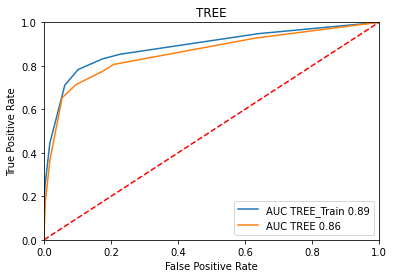

TREE CLASSIFICATION ACCURACY
TREE_Train  =  0.893246644295302
TREE  =  0.8850671140939598
------


TREE RMSE ACCURACY
TREE_Train  =  3581.7014877036095
TREE  =  4256.887056540744
------




In [ ]:
# Loan Default
WHO = "TREE"

CLM = tree.DecisionTreeClassifier(random_state=4, max_depth=5)
CLM = CLM.fit(X_train, Y_train[TARGET_BF])

TRAIN_CLM = getProbAccuracyScores(WHO + "_Train", CLM, X_train, Y_train[TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, X_test, Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

feature_cols = list(X_df.columns.values)
tree.export_graphviz(CLM, out_file='tree_f.txt',filled=True,
                     rounded=True, feature_names = feature_cols,
                     impurity=False, class_names=["Good","Bad"])
vars_tree_flag = getTreeVars(CLM, feature_cols) 

# Loss Amount
AMT = tree.DecisionTreeRegressor(max_depth=4)
AMT = AMT.fit(X_train, Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train, Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test, Y_test[TARGET_LA])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

feature_cols = list(X_df.columns.values)
vars_tree_flag = getEnsembleTreeVars(CLM, feature_cols )

TREE_CLM = TEST_CLM.copy()
TREE_AMT = TEST_AMT.copy()

In [ ]:
# Create a prediction using probability value 
print('Probability of Loan Default')
probs = fm01_Tree.predict_proba(X_train)
probs_grp1 = probs[0:10] # Lists first 10 people and their associated probability 
probs_grp1

Probability of Loan Default


array([[0.06870229, 0.93129771],
       [0.23170732, 0.76829268],
       [0.94667466, 0.05332534],
       [0.40572792, 0.59427208],
       [0.94667466, 0.05332534],
       [0.94667466, 0.05332534],
       [0.        , 1.        ],
       [0.23170732, 0.76829268],
       [0.96558989, 0.03441011],
       [0.94667466, 0.05332534]])

In [ ]:
# Predict probability of outcomes
probs = fm01_Tree.predict_proba(X_train)
probs_grp2 = probs[:,1] # Look across all rows in Column 1 
false_pos_rate_train, true_pos_rate_train, threshold = metrics.roc_curve(Y_train[TARGET_BF], probs_grp2)
# print(probs_grp2[0:10],'\n') # Grabs first 10 probabilites 

# Represents area under the ROC Curve (training data)
roc_auc_train = metrics.auc(false_pos_rate_train, true_pos_rate_train)

In [ ]:
# Predict probability of outcomes
probs = fm01_Tree.predict_proba(X_test)
probs_grp2 = probs[:,1] # Look across all rows in Column 1 
false_pos_rate_test, true_pos_rate_test, threshold = metrics.roc_curve(Y_test[TARGET_BF], probs_grp2)

# Represents area under the ROC Curve (test data)
roc_auc_test = metrics.auc(false_pos_rate_test, true_pos_rate_test)

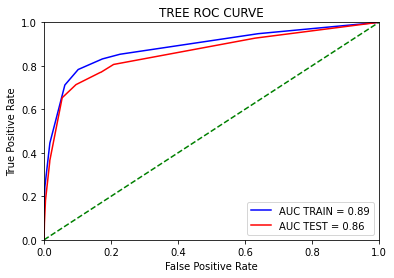

In [ ]:
# Create ROC Curve
plt.title('TREE ROC CURVE')
plt.plot(false_pos_rate_train, true_pos_rate_train, 'b',
         label='AUC TRAIN = %0.2f' % roc_auc_train, color='blue')
plt.plot(false_pos_rate_test, true_pos_rate_test, 'b',
         label='AUC TEST = %0.2f' % roc_auc_test, color='red')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###### RMSE of Decision Tree

In [ ]:
# Create a decision tree regressor with respect to TARGET_A
amt_m01_Tree = tree.DecisionTreeRegressor(random_state=4, max_depth=5)
amt_m01_Tree = amt_m01_Tree.fit(X_train, Y_train[TARGET_LA])

In [ ]:
# Score predictions for Y_pred_train and Y_pred_test
Y_pred_train = fm01_Tree.predict(X_train)
Y_pred_test = fm01_Tree.predict(X_test)

In [ ]:
# Inspect mean value for train and test
print("MEAN Train", Y_train[TARGET_LA].mean())
print("MEAN Test", Y_test[TARGET_LA].mean())

MEAN Train 11480.337458053691
MEAN Test 11499.157718120805


In [ ]:
# Perform RMSE
RMSE_TRAIN = math.sqrt(metrics.mean_squared_error(Y_train[TARGET_LA], Y_pred_train))
RMSE_TEST = math.sqrt(metrics.mean_squared_error(Y_test[TARGET_LA], Y_pred_test))
print("TREE RMSE Train:", RMSE_TRAIN)
print("TREE RMSE Test:", RMSE_TEST, '\n')

RMSE_TREE = RMSE_TEST
feature_cols = list(X_df.columns.values)
vars_tree_amt = getTreeVars(fm01_Tree, feature_cols)

TREE RMSE Train: 12455.242717475097
TREE RMSE Test: 12673.130102827317 



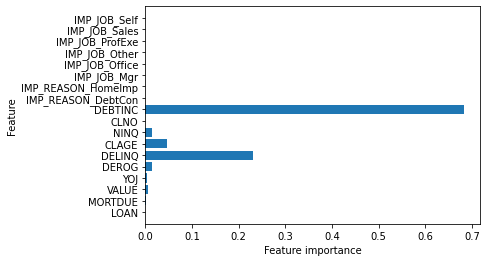

In [ ]:
def feature_importance(model):
  n_features = X_train.shape[1]
  plt.barh(np.arange(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), X_train.columns)
  plt.xlabel("Feature importance")
  plt.ylabel("Feature")
  plt.ylim(-1, n_features)
feature_importance(fm01_Tree)

### Initial Start Point Random Forest
* Finding Most Important Features

In [ ]:
# Create a RandomForestClassifier 
# Fit model to data (models are dynamic, data is static)
fm01_RF = RandomForestClassifier(random_state=4, max_depth=5)
fm01_RF = fm01_RF.fit(X_train, Y_train[TARGET_BF])

In [ ]:
# Predict probability of outcomes
probs = fm01_RF.predict_proba(X_test)
p1 = probs[:, 1]
fpr_test, tpr_test, threshold = metrics.roc_curve(Y_test[TARGET_BF], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

In [ ]:
# Store variables values in new variables
fpr_RF = fpr_test
tpr_RF = tpr_test
auc_RF = roc_auc_test

In [ ]:
# Predict probability of outcomes
probs = fm01_RF.predict_proba(X_train)
p1 = probs[:, 1]
fpr_train, tpr_train, threshold = metrics.roc_curve(Y_train[TARGET_BF], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

In [ ]:
# Gather relevant variables used in model prediction
feature_cols = list(X_df.columns.values)
vars_RF_flag = getEnsembleTreeVars(fm01_RF, feature_cols)

# Output best predictor variable/s
for i in vars_RF_flag :
   print(i)

('DEBTINC', 100)
('DELINQ', 81)
('DEROG', 49)
('CLAGE', 25)
('LOAN', 19)


In [ ]:
# Score predictions for Y_Pred_train and Y_Pred_test
Y_Pred_train = fm01_RF.predict(X_train)
Y_Pred_test = fm01_RF.predict(X_test)

In [ ]:
print("RANDOM FOREST\n")
print("Probability of Loan Default")
print("Train Accuracy:",metrics.accuracy_score(Y_train[TARGET_BF], Y_Pred_train))
print("Test Accuracy:",metrics.accuracy_score(Y_test[TARGET_BF], Y_Pred_test))

RANDOM FOREST

Probability of Loan Default
Train Accuracy: 0.8687080536912751
Test Accuracy: 0.8364093959731543


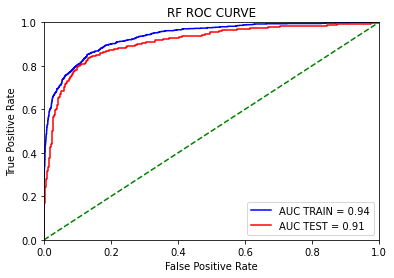

In [ ]:
# Create ROC Curve
plt.title('RF ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forest (without Regression)

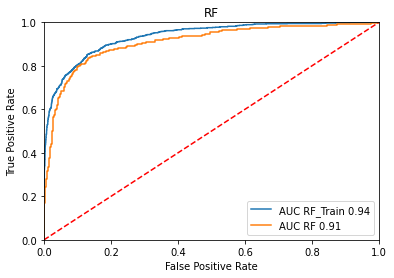

RF CLASSIFICATION ACCURACY
RF_Train  =  0.8687080536912751
RF  =  0.8364093959731543
------


RF RMSE ACCURACY
RF_Train  =  976.6989722123595
RF  =  2568.5870853792712
------




In [ ]:
# Loan Default
WHO = "RF"

CLM = RandomForestClassifier(random_state=4, max_depth=5)
CLM = CLM.fit(X_train, Y_train[TARGET_BF])

TRAIN_CLM = getProbAccuracyScores(WHO + "_Train", CLM, X_train, Y_train[ TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, X_test, Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

feature_cols = list(X_df.columns.values)
vars_RF_flag = getEnsembleTreeVars(CLM, feature_cols)

# Loss Amount
AMT = RandomForestRegressor(n_estimators=100, random_state=4)
AMT = AMT.fit( X_train, Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train, Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test, Y_test[TARGET_LA])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

feature_cols = list(X_df.columns.values)
vars_tree_amt = getEnsembleTreeVars(AMT, feature_cols) 

## for i in vars_RF_amt:
##   print(i)

RF_CLM = TEST_CLM.copy()
RF_AMT = TEST_AMT.copy()

##### RMSE of Random Forest

In [ ]:
# Create a RandomForestRegressor with respect to TARGET_A
# Fit model to data (models are dynamic, data is static)
amt_m01_RF = RandomForestRegressor(random_state=4, max_depth=5)
amt_m01_RF = amt_m01_RF.fit(X_train, Y_train[TARGET_LA])

In [ ]:
# Score predictions for X_train and X_test
Y_Pred_train = amt_m01_Tree.predict(X_train)
Y_Pred_test = amt_m01_Tree.predict(X_test)

In [ ]:
# Inspect mean value for train and test
RMSE_TRAIN = math.sqrt(metrics.mean_squared_error(Y_train[TARGET_LA],
                                                   Y_Pred_train))
RMSE_TEST = math.sqrt(metrics.mean_squared_error(Y_test[TARGET_LA],
                                                  Y_Pred_test))

print("RF RMSE Train", RMSE_TRAIN)
print("RF RMSE Test", RMSE_TEST)

RF RMSE Train 3214.616729791754
RF RMSE Test 3679.9310534755177


In [ ]:
# List the variables included in the Random Forest that predict loss amount
RMSE_RF = RMSE_TEST
feature_cols = list(X_df.columns.values)
vars_RF_amt = getEnsembleTreeVars(amt_m01_RF, feature_cols)

# Output best predictor variable/s
for i in vars_RF_amt :
   print(i)

('LOAN', 100)
('DELINQ', 74)
('CLNO', 29)
('DEBTINC', 24)


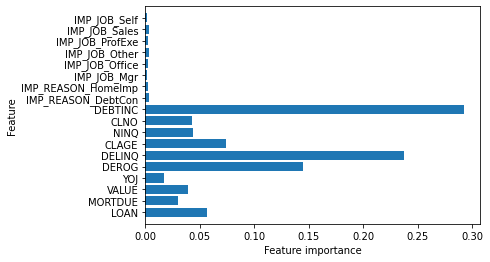

In [ ]:
def feature_importance(model):
  n_features = X_train.shape[1]
  plt.barh(np.arange(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), X_train.columns)
  plt.xlabel("Feature importance")
  plt.ylabel("Feature")
  plt.ylim(-1, n_features)
feature_importance(fm01_RF)

### Initial Start Point Gradient Boosting
* Finding Most Important Features

In [ ]:
# Create a GradientBoostingClassifier with respect to TARGET_F
fm01_GB = GradientBoostingClassifier(random_state=4, max_depth=5)
fm01_GB = fm01_GB.fit(X_train, Y_train[TARGET_BF])

In [ ]:
# Create a GradientBoostingClassifier with respect to TARGET_F
fm01_GB = GradientBoostingClassifier(random_state=4, max_depth=5)
fm01_GB = fm01_GB.fit(X_train, Y_train[TARGET_BF])

In [ ]:
# Store variables values in new variables
fpr_GB = fpr_test
tpr_GB = tpr_test
auc_GB = roc_auc_test

In [ ]:
# Predict probability of outcomes
probs = fm01_GB.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_BF], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

In [ ]:
# Predict probability of outcomes
probs = fm01_GB.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_BF], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

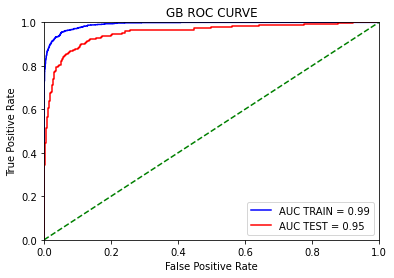

In [ ]:
plt.title('GB ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# List the variables included in the Gradient Boosting that predict loss amount
feature_cols = list(X_df.columns.values)
vars_GB_flag = getEnsembleTreeVars(fm01_GB, feature_cols)

# Output best predictor variable/s
for i in vars_GB_flag :
   print(i)

('DEBTINC', 100)
('DELINQ', 35)
('CLAGE', 19)
('VALUE', 13)


### Gradient Boosting (without Regression)

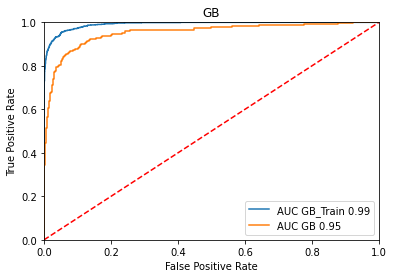

GB CLASSIFICATION ACCURACY
GB_Train  =  0.9653942953020134
GB  =  0.9177852348993288
------


GB RMSE ACCURACY
GB_Train  =  1433.629881914251
GB  =  2425.064507048414
------




In [ ]:
# Gradient Boosting
WHO = "GB"

CLM = GradientBoostingClassifier(random_state=4, max_depth=5)
CLM = CLM.fit( X_train, Y_train[TARGET_BF])

TRAIN_CLM = getProbAccuracyScores(WHO + "_Train", CLM, X_train, Y_train[TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, X_test, Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

feature_cols = list(X_df.columns.values)
vars_GB_flag = getEnsembleTreeVars(CLM, feature_cols)

# Loss Amount
AMT = GradientBoostingRegressor(random_state=4, max_depth=5)
AMT = AMT.fit(X_train, Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train, Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test, Y_test[TARGET_LA])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

feature_cols = list(X_df.columns.values )
vars_GB_amt = getEnsembleTreeVars(AMT, feature_cols)

##for i in vars_GB_amt :
##    print( i )

GB_CLM = TEST_CLM.copy()
GB_AMT = TEST_AMT.copy()

##### RMSE of Gradient Boosting

In [ ]:
# Create a GradientBoostingRegressor with respect to TARGET_A
# Fit model to data (models are dynamic, data is static)
amt_m01_GB = GradientBoostingRegressor(random_state=4, max_depth=5)
amt_m01_GB = amt_m01_GB.fit( X_train, Y_train[TARGET_LA])

In [ ]:
# Score predictions for X_train and X_test
Y_Pred_train = amt_m01_GB.predict(X_train)
Y_Pred_test = amt_m01_GB.predict(X_test)

In [ ]:
# Inspect mean value for train and test
RMSE_TRAIN = math.sqrt(metrics.mean_squared_error(Y_train[TARGET_LA], Y_Pred_train))
RMSE_TEST = math.sqrt(metrics.mean_squared_error(Y_test[TARGET_LA], Y_Pred_test))

print("GB RMSE Train:", RMSE_TRAIN)
print("GB RMSE Test:", RMSE_TEST)

GB RMSE Train: 1433.629881914251
GB RMSE Test: 2425.064507048414


In [ ]:
# List the variables included in the Gradient Boosting that predict loss amount
RMSE_GB = RMSE_TEST
feature_cols = list(X_df.columns.values)
vars_GB_amt = getEnsembleTreeVars(amt_m01_GB, feature_cols)

# Output best predictor variable/s
for i in vars_GB_amt :
   print(i)

('LOAN', 100)
('DELINQ', 63)
('DEBTINC', 60)
('CLNO', 32)
('CLAGE', 26)


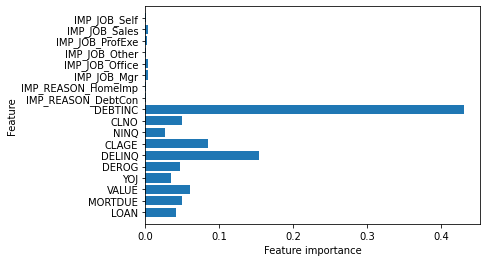

In [ ]:
def feature_importance(model):
  n_features = X_train.shape[1]
  plt.barh(np.arange(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), X_train.columns)
  plt.xlabel("Feature importance")
  plt.ylabel("Feature")
  plt.ylim(-1, n_features)
feature_importance(fm01_GB)

## Applying Regression to all variables ('REG_ALL')
 - Using `LogisticRegression()` and `LinearRegression()` on `TARGET_LA` 
 - Hyperparameters: `solver=newton-cg` outperformed `solver=liblinear`

Number of features used: 18 



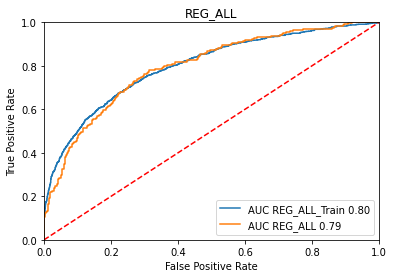

REG_ALL CLASSIFICATION ACCURACY
REG_ALL_Train  =  0.8414429530201343
REG_ALL  =  0.8137583892617449
------


REG_ALLRMSE ACCURACY
REG_ALL_Train  =  4221.416785777394
REG_ALL  =  4629.387168119021
------



LOAN DEFAULT
---------
Total Variables:  19
INTERCEPT  =  -2.3845268579535706
LOAN  =  -1.7521476006468197e-05
MORTDUE  =  -4.201280867693599e-06
VALUE  =  3.202417522965407e-06
YOJ  =  -0.012244685876579954
DEROG  =  0.561967003264887
DELINQ  =  0.7534944905331438
CLAGE  =  -0.005388714629619789
NINQ  =  0.1666122758507772
CLNO  =  -0.012663278577623399
DEBTINC  =  0.056065241887610695
IMP_REASON_DebtCon  =  -0.1797264490990743
IMP_REASON_HomeImp  =  0.10462794336250522
IMP_JOB_Mgr  =  -0.06382403552187577
IMP_JOB_Office  =  -0.7270807913222278
IMP_JOB_Other  =  -0.05192150407349553
IMP_JOB_ProfExe  =  -0.1523013164079506
IMP_JOB_Sales  =  0.6333510184616833
IMP_JOB_Self  =  0.2866781231273013

LOSS AMOUNT
---------
Total Variables:  19
INTERCEPT  =  6369.2282014920265
LOAN  =  0.14

In [ ]:
# Apply regression to all variables 
WHO = "REG_ALL"

CLM = LogisticRegression(solver='newton-cg', random_state=4, max_iter=1000)
CLM = CLM.fit(X_train, Y_train[TARGET_BF])
print("Number of features used: {}".format(np.sum(CLM.coef_ !=0)),'\n')

TRAIN_CLM = getProbAccuracyScores(WHO + '_Train', CLM, X_train, Y_train[TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, X_test, Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

# Loss Amount 
AMT = LinearRegression()
AMT = AMT.fit(X_train, Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train, Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test, Y_test[TARGET_LA])
print_Accuracy(WHO + "RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

varNames = list(X_train.columns.values)

REG_ALL_CLM_COEF = getCoefLogit(CLM, X_train)
REG_ALL_AMT_COEF = getCoefLinear(AMT, X_train)

REG_ALL_CLM = TEST_CLM.copy()
REG_ALL_AMT = TEST_AMT.copy()

#### Decision Trees (with Regression)
 * REG_TREE

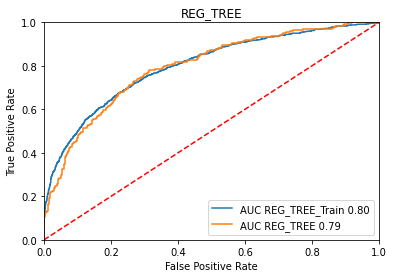

REG_TREE CLASSIFICATION ACCURACY
REG_TREE_Train  =  0.8414429530201343
REG_TREE  =  0.8137583892617449
------


REG_TREE RMSE ACCURACY
REG_TREE_Train  =  4221.416785777394
REG_TREE  =  4629.387168119021
------



LOAN DEFAULT
---------
Total Variables:  19
INTERCEPT  =  -2.3845268579535706
LOAN  =  -1.7521476006468197e-05
MORTDUE  =  -4.201280867693599e-06
VALUE  =  3.202417522965407e-06
YOJ  =  -0.012244685876579954
DEROG  =  0.561967003264887
DELINQ  =  0.7534944905331438
CLAGE  =  -0.005388714629619789
NINQ  =  0.1666122758507772
CLNO  =  -0.012663278577623399
DEBTINC  =  0.056065241887610695
IMP_REASON_DebtCon  =  -0.1797264490990743
IMP_REASON_HomeImp  =  0.10462794336250522
IMP_JOB_Mgr  =  -0.06382403552187577
IMP_JOB_Office  =  -0.7270807913222278
IMP_JOB_Other  =  -0.05192150407349553
IMP_JOB_ProfExe  =  -0.1523013164079506
IMP_JOB_Sales  =  0.6333510184616833
IMP_JOB_Self  =  0.2866781231273013

LOSS AMOUNT
---------
Total Variables:  19
INTERCEPT  =  6369.2282014920265
LOAN  

In [ ]:
# Regression Decision Tree
WHO = "REG_TREE"

CLM = LogisticRegression(solver='newton-cg', max_iter=1000)
CLM = CLM.fit(X_train, Y_train[TARGET_BF])

TRAIN_CLM = getProbAccuracyScores(WHO + "_Train", CLM, X_train, Y_train[TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, X_test, Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

# Loss Amount
AMT = LinearRegression()
AMT = AMT.fit(X_train, Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train, Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test, Y_test[TARGET_LA])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

varNames = list(X_train.columns.values)

REG_TREE_CLM_COEF = getCoefLogit(CLM, X_train)
REG_TREE_AMT_COEF = getCoefLinear(AMT, X_train)

REG_TREE_CLM = TEST_CLM.copy()
REG_TREE_AMT = TEST_AMT.copy()

In [ ]:
# Tree search
def getTreeVars(TREE, varNames):
  tree_ = TREE.tree_
  varName = [varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature]

  nameSet = set()
  for i in tree_.feature :
      if i != _tree.TREE_UNDEFINED :
          nameSet.add(i)
  nameList = list(nameSet)
  parameter_list = list()
  for i in nameList :
      parameter_list.append(varNames[i])
  return parameter_list

#### Random Forest (with Regression)
 * REG_RF

In [ ]:
# getEnsembleTreeVars() works best for decision trees,
# but not for linear regression and deep learning
def getEnsembleTreeVars(ENSTREE, varNames):
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

In [ ]:
# Create a RandomForestClassifier 
# Fit model to data (models are dynamic, data is static)
fm01_RF = RandomForestClassifier(random_state=4, max_depth=5)
fm01_RF = fm01_RF.fit(X_train, Y_train[TARGET_BF])

In [ ]:
# Predict probability of outcomes
probs = fm01_RF.predict_proba(X_test)
p1 = probs[:, 1]
fpr_test, tpr_test, threshold = metrics.roc_curve(Y_test[TARGET_BF], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

In [ ]:
# Store variables values in new variables
fpr_RF = fpr_test
tpr_RF = tpr_test
auc_RF = roc_auc_test

In [ ]:
# Predict probability of outcomes
probs = fm01_RF.predict_proba(X_train)
p1 = probs[:, 1]
fpr_train, tpr_train, threshold = metrics.roc_curve(Y_train[TARGET_BF], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

In [ ]:
# Gather relevant variables used in model prediction
feature_cols = list(X_df.columns.values)
vars_RF_flag = getEnsembleTreeVars(fm01_RF, feature_cols)

# Output best predictor variable/s
for i in vars_RF_flag :
   print(i)

('DEBTINC', 100)
('DELINQ', 81)
('DEROG', 49)
('CLAGE', 25)
('LOAN', 19)


In [ ]:
# Create a RandomForestRegressor with respect to TARGET_A
# Fit model to data (models are dynamic, data is static)
amt_m01_RF = RandomForestRegressor(random_state=4, max_depth=5)
amt_m01_RF = amt_m01_RF.fit(X_train, Y_train[TARGET_LA])

In [ ]:
# Score predictions for X_train and X_test
Y_Pred_train = amt_m01_Tree.predict(X_train)
Y_Pred_test = amt_m01_Tree.predict(X_test)

In [ ]:
# Inspect mean value for train and test
RMSE_TRAIN = math.sqrt(metrics.mean_squared_error(Y_train[TARGET_LA],
                                                   Y_Pred_train))
RMSE_TEST = math.sqrt(metrics.mean_squared_error(Y_test[TARGET_LA],
                                                  Y_Pred_test))

print("RF RMSE Train", RMSE_TRAIN)
print("RF RMSE Test", RMSE_TEST)

RF RMSE Train 3214.616729791754
RF RMSE Test 3679.9310534755177


In [ ]:
# List the variables included in the Random Forest that predict loss amount
RMSE_RF = RMSE_TEST
feature_cols = list(X_df.columns.values)
vars_RF_amt = getEnsembleTreeVars(amt_m01_RF, feature_cols)

# Output best predictor variable/s
for i in vars_RF_amt :
   print(i)

('LOAN', 100)
('DELINQ', 74)
('CLNO', 29)
('DEBTINC', 24)




('DEBTINC', 100)
('DELINQ', 81)
('DEROG', 49)
('CLAGE', 25)
('LOAN', 19)


('LOAN', 100)
('DELINQ', 74)
('CLNO', 29)
('DEBTINC', 24)




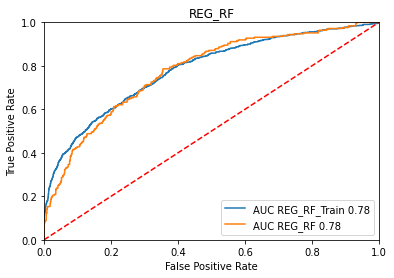

REG_RF CLASSIFICATION ACCURACY
REG_RF_Train  =  0.8395553691275168
REG_RF  =  0.8104026845637584
------


REG_RF RMSE ACCURACY
REG_RF_Train  =  4287.923029642564
REG_RF  =  4698.154210845632
------



LOAN DEFAULT
---------
Total Variables:  6
INTERCEPT  =  -2.5174895862721245
DEBTINC  =  0.05436999828065857
DELINQ  =  0.7097927702749606
DEROG  =  0.6088324276343252
CLAGE  =  -0.00635120962093763
LOAN  =  -1.737070495148116e-05

LOSS AMOUNT
---------
Total Variables:  5
INTERCEPT  =  5445.363431497909
LOAN  =  0.15184399579180294
DELINQ  =  1030.2012924569378
CLNO  =  63.283914974745926
DEBTINC  =  41.22886729817458


In [ ]:
# Random Forest
WHO = "REG_RF"

# Variable selection for TARGET_BF
print('\n')
RF_flag = []
for i in vars_RF_flag:
    print(i)
    theVar = i[0]
    RF_flag.append(theVar)

# Variable selection for TARGET_LA
print('\n')
RF_amt = []
for i in vars_RF_amt:
    print(i)
    theVar = i[0]
    RF_amt.append(theVar)
print('\n')

CLM = LogisticRegression(solver='newton-cg', max_iter=1000)
CLM = CLM.fit(X_train[RF_flag], Y_train[TARGET_BF])

TRAIN_CLM= getProbAccuracyScores(WHO + "_Train", CLM, X_train[RF_flag], Y_train[TARGET_BF])
TEST_CLM= getProbAccuracyScores(WHO, CLM, X_test[RF_flag], Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

# Loss Amount
AMT = LinearRegression()
AMT = AMT.fit(X_train[RF_amt], Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train[RF_amt], Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test[RF_amt], Y_test[TARGET_LA])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])


REG_RF_CLM_COEF = getCoefLogit(CLM, X_train[RF_flag])
REG_RF_AMT_COEF = getCoefLinear(AMT, X_train[RF_amt])

REG_RF_CLM = TEST_CLM.copy()
REG_RF_AMT = TEST_AMT.copy()

#### Gradient Boosting (with Regression)



('DEBTINC', 100)
('DELINQ', 35)
('CLAGE', 19)
('VALUE', 13)


('LOAN', 100)
('DELINQ', 63)
('DEBTINC', 60)
('CLNO', 32)
('CLAGE', 26)




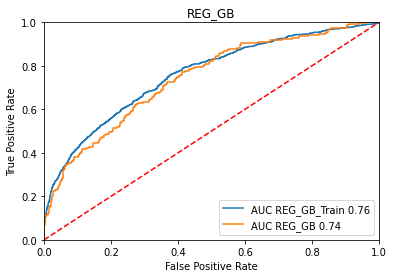

REG_GB CLASSIFICATION ACCURACY
REG_GB_Train  =  0.829488255033557
REG_GB  =  0.8112416107382551
------


REG_GB RMSE ACCURACY
REG_GB_Train  =  4264.611779717563
REG_GB  =  4660.879535990802
------



LOAN DEFAULT
---------
Total Variables:  5
INTERCEPT  =  -2.390616602764303
DEBTINC  =  0.051796126841496294
DELINQ  =  0.7825024256559359
CLAGE  =  -0.006832082389506327
VALUE  =  -1.1063890110348983e-06

LOSS AMOUNT
---------
Total Variables:  6
INTERCEPT  =  6305.294651337504
LOAN  =  0.15496195631153445
DELINQ  =  1021.0884698980844
DEBTINC  =  36.246496228702554
CLNO  =  74.69555690853672
CLAGE  =  -5.50736345240648


In [ ]:
# Regression Gradient Boosting
WHO = "REG_GB"

# Variable selection for TARGET_BF
print('\n')
GB_flag = []
for i in vars_GB_flag:
    print(i)
    theVar = i[0]
    GB_flag.append(theVar)

# Variable selection for TARGET_LA
print('\n')
GB_amt = []
for i in vars_GB_amt:
    print(i)
    theVar = i[0]
    GB_amt.append(theVar)
print('\n')

CLM = LogisticRegression(solver='newton-cg', max_iter=1000)
CLM = CLM.fit(X_train[GB_flag], Y_train[ TARGET_BF])

TRAIN_CLM = getProbAccuracyScores(WHO + "_Train", CLM, X_train[GB_flag], Y_train[TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, X_test[GB_flag], Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

# Loan Default
AMT = LinearRegression()
AMT = AMT.fit(X_train[GB_amt], Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train[GB_amt], Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test[GB_amt], Y_test[TARGET_LA])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

REG_GB_CLM_COEF = getCoefLogit(CLM, X_train[GB_flag])
REG_GB_AMT_COEF = getCoefLinear(AMT, X_train[GB_amt])

REG_GB_CLM = TEST_CLM.copy()
REG_GB_AMT = TEST_AMT.copy()

#### Stepwise (with Regression)

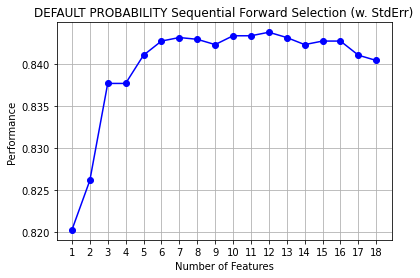

 ................... 
argmax
feature_names    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 17)
avg_score                                       0.84375
Name: 12, dtype: object
 ................... 
('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '13', '17')
LOAN
MORTDUE
VALUE
YOJ
DEROG
DELINQ
CLAGE
NINQ
CLNO
DEBTINC
IMP_JOB_Office
IMP_JOB_Self


1000000 loops, best of 5: 1.03 µs per loop
peak memory: 545.60 MiB, increment: 0.07 MiB


In [ ]:
U_train = X_train
stepVarNames = list(U_train.columns.values)
maxCols = U_train.shape[1]

sfs = SFS(LogisticRegression(solver='newton-cg', max_iter=1000),
           k_features=(1, maxCols),
           forward=True,
           floating=False,
           cv=3
           )
sfs.fit(U_train.values, Y_train[ TARGET_BF].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None)
plt.title('DEFAULT PROBABILITY Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[['feature_names', 'avg_score']]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[maxIndex, ]
stepVars = stepVars.feature_names
print(stepVars)

finalStepVars = []
for i in stepVars:
    index = int(i)
    try:
        theName = stepVarNames[index]
        finalStepVars.append(theName)
    except:
        pass

for i in finalStepVars:
    print(i)

print('\n')
%timeit sum(range(100))
%memit

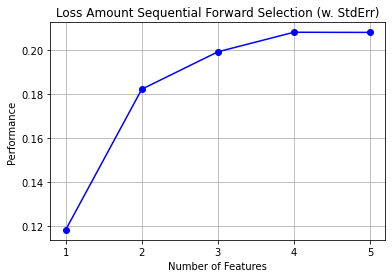

 ................... 
argmax
feature_names    (0, 1, 3, 4)
avg_score            0.208153
Name: 4, dtype: object
 ................... 
('0', '1', '3', '4')
LOAN
DELINQ
CLNO
CLAGE


In [ ]:
# Reduces number of features used
U_train = X_train[finalStepVars]
U_test = X_test[finalStepVars]

V_train = X_train[GB_amt]
stepVarNames = list(V_train.columns.values)
maxCols = V_train.shape[1]

sfs = SFS( LinearRegression(),
           k_features=(1, maxCols),
           forward=True,
           floating=False,
           scoring = 'r2',
           cv=5
           )
sfs.fit(V_train.values, Y_train[TARGET_LA].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('Loss Amount Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
dfm = dfm[['feature_names', 'avg_score']]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print(dfm.iloc[maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[maxIndex, ]
stepVars = stepVars.feature_names
print(stepVars)

finalStepVars = []
for i in stepVars:
    index = int(i)
    try:
        theName = stepVarNames[index]
        finalStepVars.append(theName)
    except:
        pass

for i in finalStepVars:
    print(i)

V_train = X_train[finalStepVars]
V_test = X_test[finalStepVars]

# <a name="1">Create a TensorFlow Model To Predict Loan Defaults:</a>

* For your model, do the following:
  - Try at least three different Activation Functions
  - Try one and two hidden layers
  - Try using a Dropout Layer
  - Explore using a variable selection technique

* For each of the models
  - Calculate the accuracy of the model on both the training and test data set
  - Create a graph that shows the ROC curves for both the training and test data set. 
  - Clearly label each curve and display the Area Under the ROC curve.
  - Display a ROC curve for the test data with all your models on the same graph (tree based, regression, and TF). 
  - Discuss which one is the most accurate. Which one would you recommend using?

## Neural Network (PREDICT LOAN DEFAULT)
* Input Layer
* 1st Hidden Layer
* Single Dropout Layer
* 2nd Hidden Layer
* Output Layer
* **relu** and **softmax** Activation Functions
* Calculate model accuracy on **TRAINING** and **TEST** data
* Create a ROC curve for **TRAINING** and **TEST** data
* Display ROC curve for **TEST** data with all models on same graph


In [ ]:
theScaler = MinMaxScaler()
theScaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

##### Notes on function() below
* predict.proba() is deprecated, adjusted to use predict()

In [ ]:
# Fuction to predict accuracy of scores
def get_TF_ProbAccuracyScores( NAME, MODEL, X, Y ) :
    probs = MODEL.predict( X )
    pred_list = []
    for p in probs :
        pred_list.append( np.argmax( p ) )
    pred = np.array( pred_list )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

In [ ]:
# Callable bookeeping technique
WHO = "TensorFlow"   

In [ ]:
# Standardize
U_train = theScaler.transform(X_train)
U_test = theScaler.transform(X_test)

U_train = pd.DataFrame( U_train )
U_test = pd.DataFrame( U_test )

U_train.columns = list( X_train.columns.values )
U_test.columns = list( X_train.columns.values )

U_train = U_train[ GB_flag ]
U_test = U_test[ GB_flag ]

In [ ]:
# Define variable functions
F_theShapeSize = U_train.shape[1]
F_theActivation = tf.keras.activations.relu
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
F_theEpochs = 100

F_theUnits = int( 2*F_theShapeSize )
F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation,
                                   input_dim=F_theShapeSize )
F_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
F_LAYER_02 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )

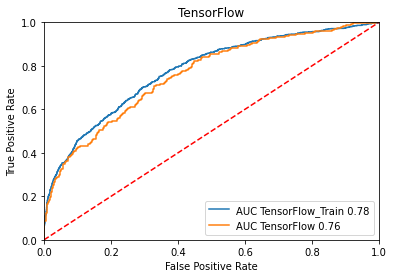

TensorFlow CLASSIFICATION ACCURACY
TensorFlow_Train  =  0.832005033557047
TensorFlow  =  0.8171140939597316
------


TensorFlow RMSE ACCURACY
TensorFlow_Train  =  11256.989695010208
TensorFlow  =  11495.455512442735
------




In [ ]:
# Define NN
CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_DROP )
CLM.add( F_LAYER_02 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_BF], epochs=F_theEpochs, verbose=False )

# Determine Probabilities
TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_BF ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_BF ] )

# Display ROC Curve
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

# Display Accuracy
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )
TF_CLM = TEST_CLM.copy()
TF_AMT = TEST_AMT.copy()

# <a name="2">Create a TensorFlow Model to Predict Loss Given Default</a>

## Neural Network (PREDICT LOSS AMT GIVEN DEFAULT)
* Input Layer
* Single Hidden Layer
* No Dropout Layer
* **Sigmoid** and **softplus** Activation Functions
* Calculate model accuracy on **TRAINING** and **TEST** data
* Create a ROC curve for **TRAINING** and **TEST** data
* Display ROC curve for **TEST** data with all models on same graph


In [ ]:
# Standardize
V_train = theScaler.transform( X_train )
V_test = theScaler.transform( X_test )

V_train = pd.DataFrame( V_train )
V_test = pd.DataFrame( V_test )

V_train.columns = list( X_train.columns.values )
V_test.columns = list( X_train.columns.values )

V_train = V_train[ GB_amt ]
V_test = V_test[ GB_amt ]

In [ ]:
# Define variable functions
A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.sigmoid
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 800

A_theUnits = int( 2*A_theShapeSize  )
A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation,
                                   input_dim=A_theShapeSize )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.softplus )

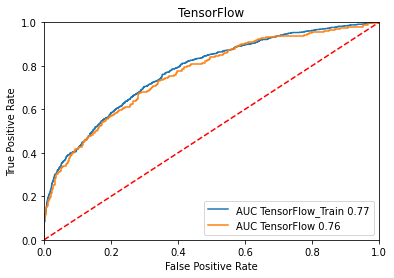

TensorFlow CLASSIFICATION ACCURACY
TensorFlow_Train  =  0.8309563758389261
TensorFlow  =  0.8187919463087249
------


TensorFlow RMSE ACCURACY
TensorFlow_Train  =  11256.989695010208
TensorFlow  =  11495.455512442735
------




In [ ]:
# Define NN
AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Y_train[TARGET_LA], epochs=A_theEpochs, verbose=False )

# Determine Probabilities
TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train[GB_amt], Y_train[TARGET_LA] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test[GB_amt], Y_test[TARGET_LA] )

# Display ROC Curve
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

# Display Accuracy
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )
TF_CLM = TEST_CLM.copy()
TF_AMT = TEST_AMT.copy()

# <a name="3">Best Model Explanation</a>
## Consolidated ROC Curve (Best Model)
### The Gradient Boosting model outperformed the Neural Network in test accuracy (by +19%). TensorFlow RMSE was significantly higher. I suspect this is because of the learning process required to produce the target output. It is not a precise science. 
### A lot of "trial and error" is required - which is similar to how humans learn (as ANNs are based on a human's brain / neural network).
### This does feel disappointing because I expected a much more "magical" outcome using a NN considering the buzz the term carries in the industry. But once you dive deep, and understand what it is, how it works, and why it doesn't for certain applications, the "hype" fades and I begin thinking more critically about how and when I would actually need to implement a NN to solve a real-world problem.
### Decisions Trees and Linear Regression are hard to beat

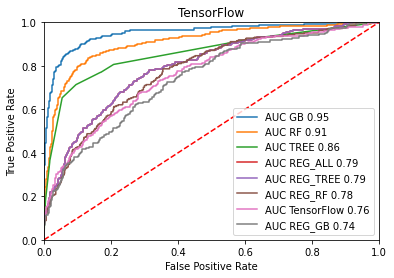

ALL CLASSIFICATION ACCURACY
GB  =  0.9177852348993288
TREE  =  0.8850671140939598
RF  =  0.8364093959731543
TensorFlow  =  0.8187919463087249
REG_ALL  =  0.8137583892617449
REG_TREE  =  0.8137583892617449
REG_GB  =  0.8112416107382551
REG_RF  =  0.8104026845637584
------


ALL DAMAGE MODEL ACCURACY
GB  =  2425.064507048414
RF  =  2568.5870853792712
TREE  =  4256.887056540744
REG_ALL  =  4629.387168119021
REG_TREE  =  4629.387168119021
REG_GB  =  4660.879535990802
REG_RF  =  4698.154210845632
TensorFlow  =  11495.455512442735
------




In [ ]:
ALL_CLM = [ TREE_CLM, RF_CLM, GB_CLM, REG_ALL_CLM, REG_TREE_CLM, REG_RF_CLM, 
REG_GB_CLM, TF_CLM ]

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )

print_ROC_Curve( WHO, ALL_CLM ) 

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )

print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )

ALL_AMT = [ TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT, REG_RF_AMT, 
REG_GB_AMT, TF_AMT ]

ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )

print_Accuracy( "ALL DAMAGE MODEL ACCURACY", ALL_AMT )